# Rides Forcasting
### The goal is to predict real taxi rides given historical rides
We build models for 2 cases.
1. Case 1- 'week to week' prediction using XGBoost Regressor (using data from the previous week for prediction)
2. Case 2 - building Forcasting using SARIMA model (not using previous week's data, learning seasonality through sarima model only)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

## Load Data

In [2]:
df_rides = pd.read_csv('rides.csv')
df_rides.head()

,RIDE_ID,created_on,created_on_hour,started_on,completed_on,distance_travelled
0,0,2016-06-04 00:10:19,2016-06-04 00:00:00,2016-06-04 00:18:49,2016-06-04 00:27:32,8459.0
1,1,2016-06-04 01:47:39,2016-06-04 01:00:00,2016-06-04 01:50:12,2016-06-04 01:51:49,443.0
2,2,2016-06-04 03:13:07,2016-06-04 03:00:00,2016-06-04 03:16:02,2016-06-04 03:17:57,568.0
3,3,2016-06-04 09:52:35,2016-06-04 09:00:00,2016-06-04 10:05:13,2016-06-04 10:13:38,4051.0
4,4,2016-06-04 10:23:25,2016-06-04 10:00:00,2016-06-04 10:24:25,2016-06-04 10:26:07,790.0


In [3]:
df_rides.shape

(1494125, 6)

## Data Exploration

In [4]:
df_hourly_rides = df_rides.groupby('created_on_hour')['RIDE_ID'].count().reset_index().rename(columns={'RIDE_ID': 'rides'})
df_hourly_rides['created_on_hour'] = pd.to_datetime(df_hourly_rides['created_on_hour'])
df_hourly_rides.head()

,created_on_hour,rides
0,2016-06-04 00:00:00,1
1,2016-06-04 01:00:00,1
2,2016-06-04 03:00:00,1
3,2016-06-04 09:00:00,1
4,2016-06-04 10:00:00,1


In [5]:
max(df_hourly_rides.created_on_hour)

Timestamp('2017-04-13 18:00:00')

## Plotting rides overtime


#### 1. We can clearly see a trend in the range of 16/6/4 - 16/10/8. In this range ,the number of rides increases slowly and from the end of June, we can see that the number of rides increases from week to week. After that range that number of rides stablizes and there's no clear trend. A possible explanation for this trend is that maybe this taxi service had just started to operate in this city in June 2016 and the first 4 months had less rides.

#### 2. There's seasonality in the data. It's clear that the number of rides gets to a pick every weekend (on a Saturday), drop after the weekend and climbes back up throughout the week until it gets to a pick in the following weekend.  ####

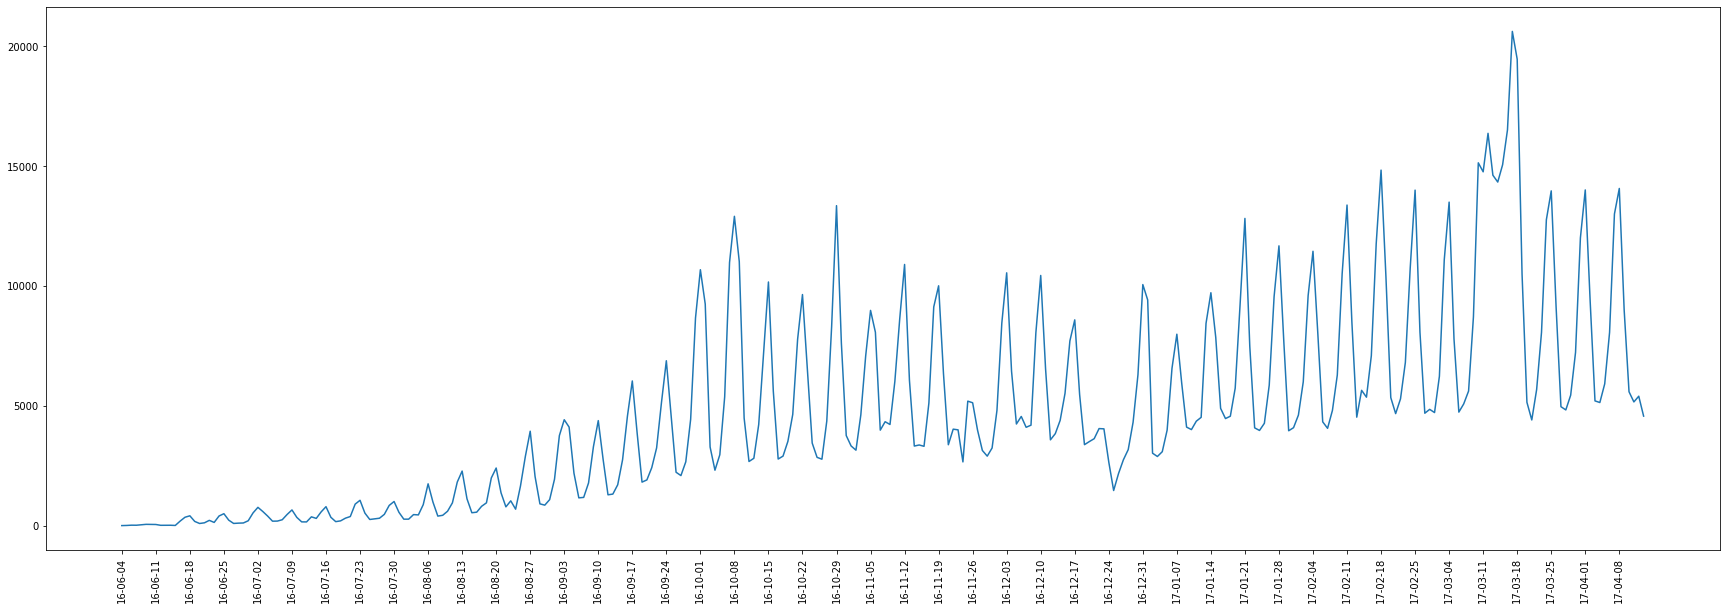

In [6]:
df_daily_rides = df_hourly_rides.groupby(df_hourly_rides['created_on_hour'].dt.strftime('%y-%m-%d')).sum().reset_index()
plt.rcParams["figure.figsize"] = (30,10)
plt.plot('created_on_hour', 'rides', data = df_daily_rides)
locs, labels = plt.xticks() 
plt.xticks(np.arange(0, len(locs), step=7), rotation=90);

## Plotting rides distance histogram

### The rides distance is presented in a logarithmic scale since the distance range is very wide and skewed. 

### The distance travelled distributes closely to normal. There's a left tale that is caused by short rides. Some of those rides might be considered as noise 

In [7]:
df_rides.describe()

,RIDE_ID,distance_travelled
count,1.494125e+06,1.494123e+06
mean,7.470620e+05,8.768291e+03
std,4.313169e+05,4.686613e+04
min,0.000000e+00,0.000000e+00
25%,3.735310e+05,3.192000e+03
50%,7.470620e+05,5.843000e+03
75%,1.120593e+06,1.186200e+04
max,1.494124e+06,4.302576e+07


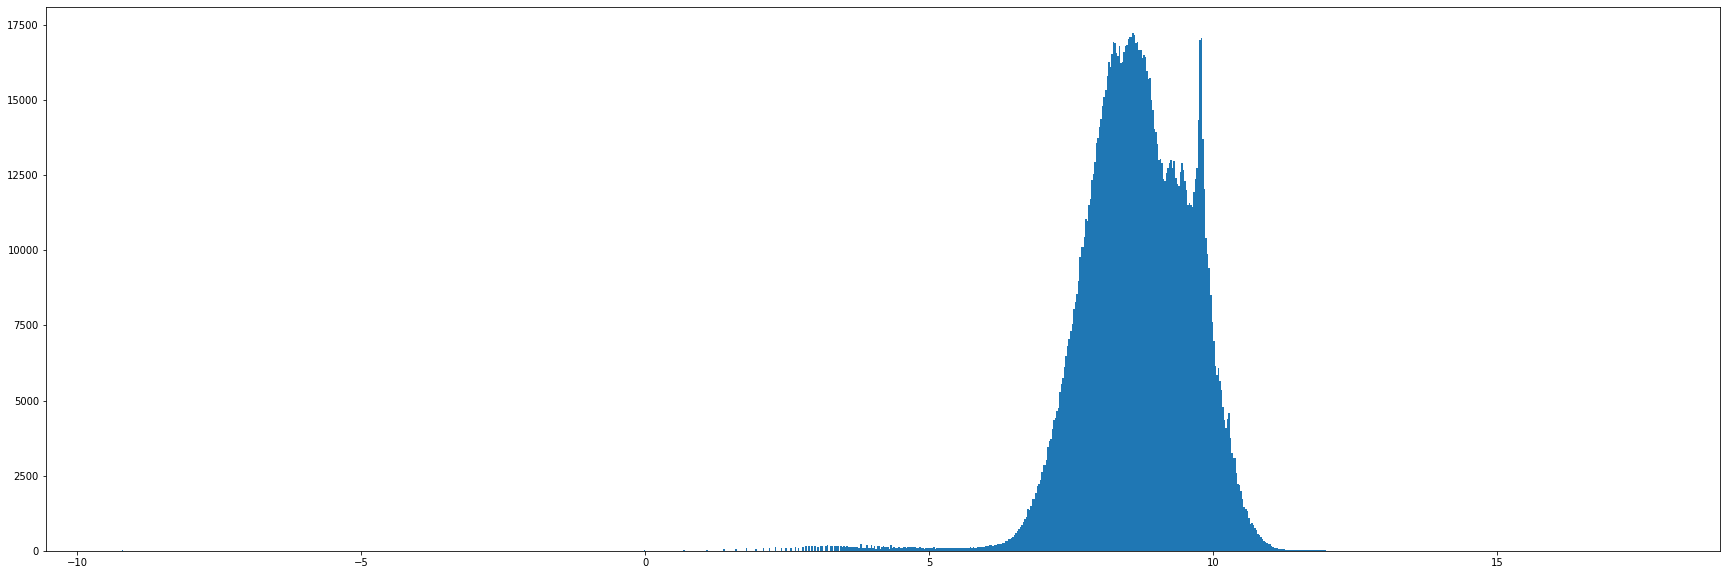

In [8]:
# use epsilon to enable log(0)
eps = 0.0001
# change the min distance to not consider noise (rides that are less than x meters)
min_dist = 0
plt.hist(np.log(df_rides[df_rides.distance_travelled >= min_dist].distance_travelled + eps),bins=1000);

## Preprocessing

In [9]:
df_times = pd.read_csv('times.csv')
df_times['datetime'] = pd.to_datetime(df_times['datetime'])
df_times.head()

,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 02:00:00,5,6,4,2016,22,156,False,None,2
3,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
4,2016-06-04 04:00:00,5,6,4,2016,22,156,False,None,4


### Merging dataframes

In [10]:
# merge dataframes on the unique key 
df_mrg = pd.merge(df_hourly_rides, df_times,how = 'left', left_on= 'created_on_hour', right_on = 'datetime')
df_mrg.head()

,created_on_hour,rides,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour
0,2016-06-04 00:00:00,1,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0
1,2016-06-04 01:00:00,1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1
2,2016-06-04 03:00:00,1,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3
3,2016-06-04 09:00:00,1,2016-06-04 09:00:00,5,6,4,2016,22,156,False,None,9
4,2016-06-04 10:00:00,1,2016-06-04 10:00:00,5,6,4,2016,22,156,False,None,10


### Building rides lag feature

#### In order to create the lag feaure we need to make a function that for every data point looks back in the data and searches for the number of rides on the previous week and on the same hour. * We can not just use a simple shift since the data does not appear in uniform jumps (as we can see in the above table - df_mrg.head)

In [11]:
max(df_mrg[df_mrg.year==2016].dayofyear)

366

In [12]:
df_mrg['adapted_days_count'] = np.where(df_mrg.year == 2016, df_mrg.dayofyear,df_mrg.dayofyear+366)

In [13]:
# get the number of rides at the previous week on the exact same hour
def prev_week_rides(x,df):
    year = x.year
    hour = x.hour
    prev_week = x.adapted_days_count - 7
    last_week_rides = df[(df.year == year) & (df.adapted_days_count == prev_week) & (df.hour == hour)].rides
    rides = int(last_week_rides) if(len(last_week_rides) > 0) else np.nan
    return(rides)

li = []
for _,row in df_mrg.iterrows():
    li.append(prev_week_rides(row,df_mrg))
df_mrg['rides_last_week'] = li

In [14]:
# In 'rides_last_week' we get NaN values if there weren't any rides on the same hour in the previous week 
df_mrg.head()

,created_on_hour,rides,datetime,weekday,month,day,year,weekofyear,dayofyear,us_holiday,us_holiday_type,hour,adapted_days_count,rides_last_week
0,2016-06-04 00:00:00,1,2016-06-04 00:00:00,5,6,4,2016,22,156,False,None,0,156,NaN
1,2016-06-04 01:00:00,1,2016-06-04 01:00:00,5,6,4,2016,22,156,False,None,1,156,NaN
2,2016-06-04 03:00:00,1,2016-06-04 03:00:00,5,6,4,2016,22,156,False,None,3,156,NaN
3,2016-06-04 09:00:00,1,2016-06-04 09:00:00,5,6,4,2016,22,156,False,None,9,156,NaN
4,2016-06-04 10:00:00,1,2016-06-04 10:00:00,5,6,4,2016,22,156,False,None,10,156,NaN


## Features Correlation
### As we can see in the correlation heatmap, there's a very strong correlation between the the rides and last week's ride (correlation of 0.84)

In [15]:
import seaborn as sns

c:\python37\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

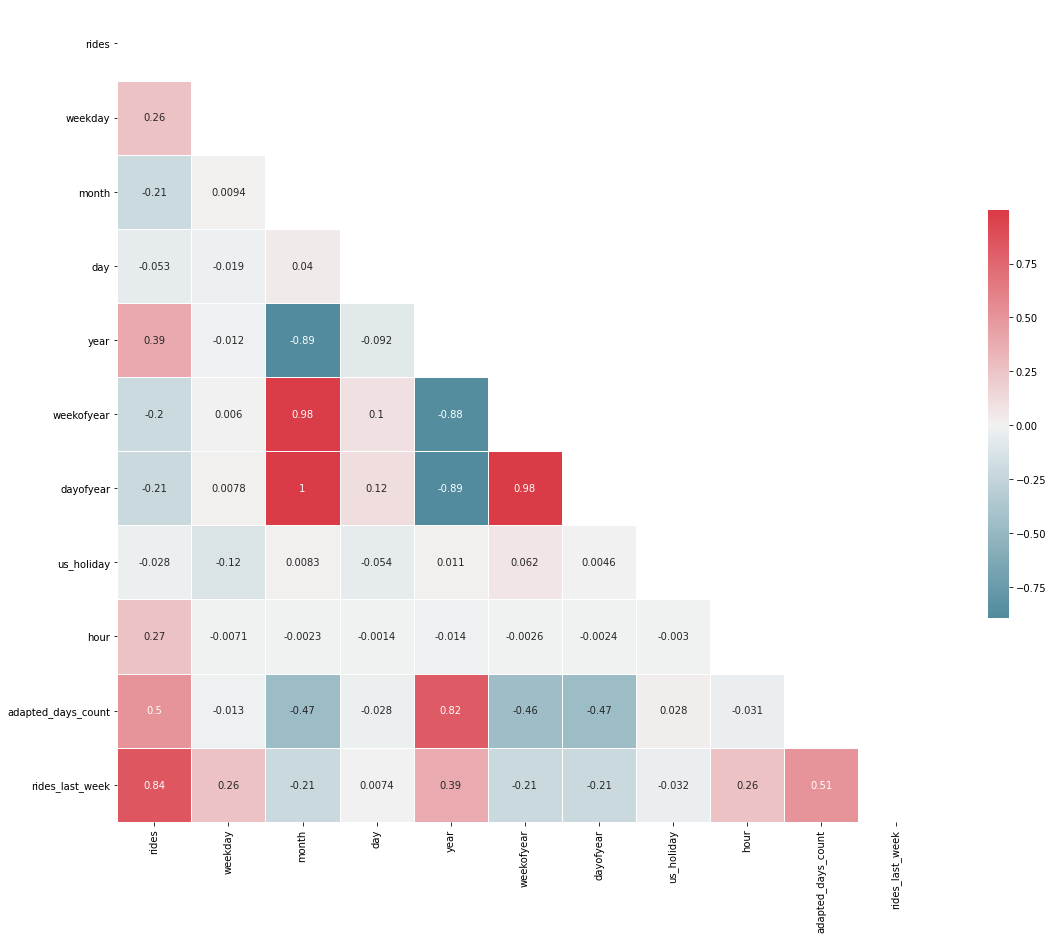

In [16]:
corr = df_mrg.iloc[:,1:].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,annot=True,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model

In [17]:
from sklearn.metrics import mean_absolute_error

#### Before we start building the models, we transform some qualitative features to one-hot encoded features. This step is needed for the one of the models that we use later on 

In [18]:
def one_hot_encoder(df, column_to_onehot, drop = True):
    # Get one hot encoding of the column
    one_hot = pd.get_dummies(df[column_to_onehot])
    one_hot = one_hot.add_suffix(f'_{column_to_onehot}')
    # Drop the column as it is now encoded
    if(drop):
        df = df.drop(column_to_onehot,axis = 1)
    # Join the encoded df
    df = df.join(one_hot)
    return df

In [19]:
df_mrg = one_hot_encoder(df_mrg,'month')
df_mrg = one_hot_encoder(df_mrg,'year', False)
df_mrg = one_hot_encoder(df_mrg,'hour', False)
df_mrg = one_hot_encoder(df_mrg,'us_holiday')
df_mrg = one_hot_encoder(df_mrg, 'us_holiday_type')

## Baseline model

### First, we build a very simple baseline model. This model averages the number of rides in the training set that happened on the same day (Sunday-Saturday) and the same hour (for example, the average number of rides that occured on all Sundays at 13:00) 

#### We start the training data from 2016/10/8. The data before that date do not represent the rides distribution correctlly for the reasons we mentioned in the first task

In [20]:
train = df_mrg[(df_mrg.datetime >= '2016-10-08 00:00:00') & (df_mrg.datetime < '2017-03-30 00:00:00')]
test = df_mrg[(df_mrg.datetime >= '2017-03-30 00:00:00') & (df_mrg.datetime < '2017-04-13 00:00:00')]

In [21]:
averages = train.groupby(['day','hour'])[['rides']].mean().reset_index().copy()
averages.columns  = ['day', 'hour', 'average_rides']

In [22]:
averages.head()

,day,hour,average_rides
0,1,0,436.8
1,1,1,407.4
2,1,2,340.2
3,1,3,147.6
4,1,4,90.2


In [23]:
def avg_baesline_model(x,df):
    week_day = x.day
    hour = x.hour
    rides = df[(df.hour == hour) & (df.day == week_day)].average_rides
    return float(rides)

In [24]:
# apply the baseline model on the training set
baseline_preds_train = list(train.apply(lambda x : avg_baesline_model(x,averages), axis=1))

In [25]:
print(f'The MAE on the training set is {mean_absolute_error(train.rides,baseline_preds_train)}')

The MAE on the training set is 139.53481088894242


In [26]:
# apply the baseline model on the test set
baseline_preds = list(test.apply(lambda x : avg_baesline_model(x,averages), axis=1))

In [27]:
print(f'The MAE on the test set is {mean_absolute_error(test.rides,baseline_preds)}')

The MAE on the test set is 195.9829365079365


## Models


### We are asked to predict the number of rides in the last two weeks of the data. We address two cases and for each case we run a different model
 * #### 1. A week-to-week prediction : We assume that in both the first and the second week, we know the previous week's number of rides. This case is a bit problematic since we use information from the training data (the lag feature). Though, we show this case because this is a possible business cases (predict the number of rides in the next week given the current week's data). For this case we want to use a non-linear regressor. We use XGBoost regressor. 

* #### 2. A time series forecast. In this case we don't use the last week's rides *or any other information (only ride time and number of rides). The forecast is done by an auto-regressive model that learns the trends and seasonality of the data. For this case we use SARIMAX. 

# CASE 1 : XGBoost model

In [28]:
df_mrg.head(2)

,created_on_hour,rides,datetime,weekday,day,year,weekofyear,dayofyear,hour,adapted_days_count,...,Columbus Day_us_holiday_type,Independence Day_us_holiday_type,Labor Day_us_holiday_type,"Martin Luther King, Jr. Day_us_holiday_type",New Year's Day_us_holiday_type,New Year's Day (Observed)_us_holiday_type,None_us_holiday_type,Thanksgiving_us_holiday_type,Veterans Day_us_holiday_type,Washington's Birthday_us_holiday_type
0,2016-06-04 00:00:00,1,2016-06-04 00:00:00,5,4,2016,22,156,0,156,...,0,0,0,0,0,0,1,0,0,0
1,2016-06-04 01:00:00,1,2016-06-04 01:00:00,5,4,2016,22,156,1,156,...,0,0,0,0,0,0,1,0,0,0


In [29]:
df_mrg.columns

Index(['created_on_hour', 'rides', 'datetime', 'weekday', 'day', 'year',
       'weekofyear', 'dayofyear', 'hour', 'adapted_days_count',
       'rides_last_week', '1_month', '2_month', '3_month', '4_month',
       '6_month', '7_month', '8_month', '9_month', '10_month', '11_month',
       '12_month', '2016_year', '2017_year', '0_hour', '1_hour', '2_hour',
       '3_hour', '4_hour', '5_hour', '6_hour', '7_hour', '8_hour', '9_hour',
       '10_hour', '11_hour', '12_hour', '13_hour', '14_hour', '15_hour',
       '16_hour', '17_hour', '18_hour', '19_hour', '20_hour', '21_hour',
       '22_hour', '23_hour', 'False_us_holiday', 'True_us_holiday',
       'Christmas Day_us_holiday_type',
       'Christmas Day (Observed)_us_holiday_type',
       'Columbus Day_us_holiday_type', 'Independence Day_us_holiday_type',
       'Labor Day_us_holiday_type',
       'Martin Luther King, Jr. Day_us_holiday_type',
       'New Year's Day_us_holiday_type',
       'New Year's Day (Observed)_us_holiday_type', 'No

In [30]:
y = 'rides'
X = ['rides_last_week','1_month', '2_month', '3_month', '4_month',
       '6_month', '7_month', '8_month', '9_month', '10_month', '11_month',
       '12_month', '2016_year', '2017_year', '0_hour', '1_hour', '2_hour',
       '3_hour', '4_hour', '5_hour', '6_hour', '7_hour', '8_hour', '9_hour',
       '10_hour', '11_hour', '12_hour', '13_hour', '14_hour', '15_hour',
       '16_hour', '17_hour', '18_hour', '19_hour', '20_hour', '21_hour',
       '22_hour', '23_hour','False_us_holiday', 'True_us_holiday',
       'Christmas Day_us_holiday_type',
       'Christmas Day (Observed)_us_holiday_type',
       'Columbus Day_us_holiday_type', 'Independence Day_us_holiday_type',
       'Labor Day_us_holiday_type',
       'Martin Luther King, Jr. Day_us_holiday_type',
       "New Year's Day_us_holiday_type",
       "New Year's Day (Observed)_us_holiday_type", "None_us_holiday_type",
       'Thanksgiving_us_holiday_type', 'Veterans Day_us_holiday_type',
       "Washington's Birthday_us_holiday_type"]

X_train = train[X]
y_train = train[y]
X_test = test[X]
y_test = test[y]

In [31]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [32]:
xgb = XGBRegressor()
xgb.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [33]:
print( f'The MAE of the train set is {mean_absolute_error(y_train,xgb.predict(X_train))}')
print( f'The MAE of the test set is {mean_absolute_error(y_test,xgb.predict(X_test))}')

The MAE of the train set is 49.2940197138004
The MAE of the test set is 65.89680331661587


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

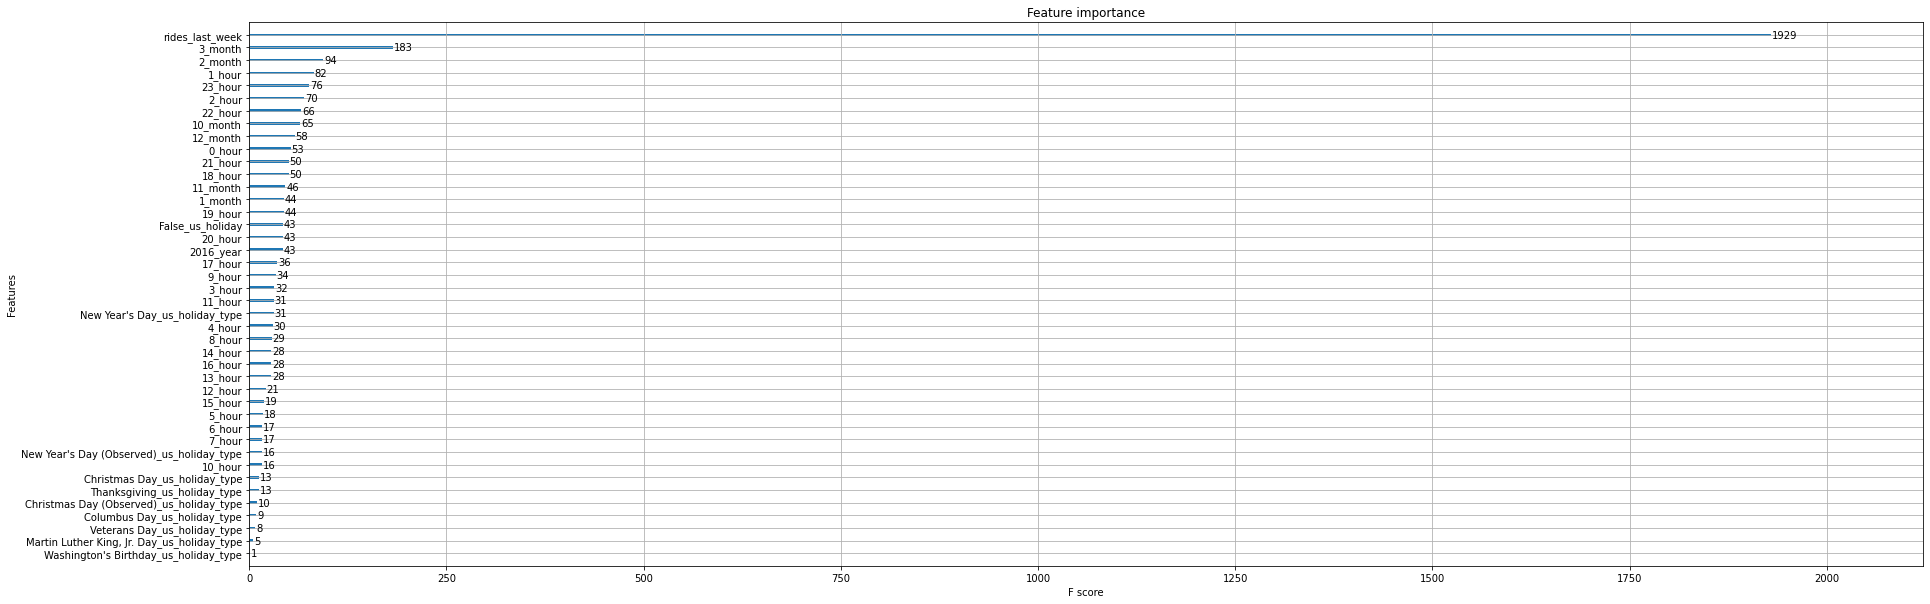

In [34]:
xgb.get_booster().feature_names = list(X_train)
plot_importance(xgb)

In [35]:
xtest_copy = X_test.copy()
xtest_copy['y_pred_xgb'] = xgb.predict(X_test)
xtest_copy['y'] = y_test

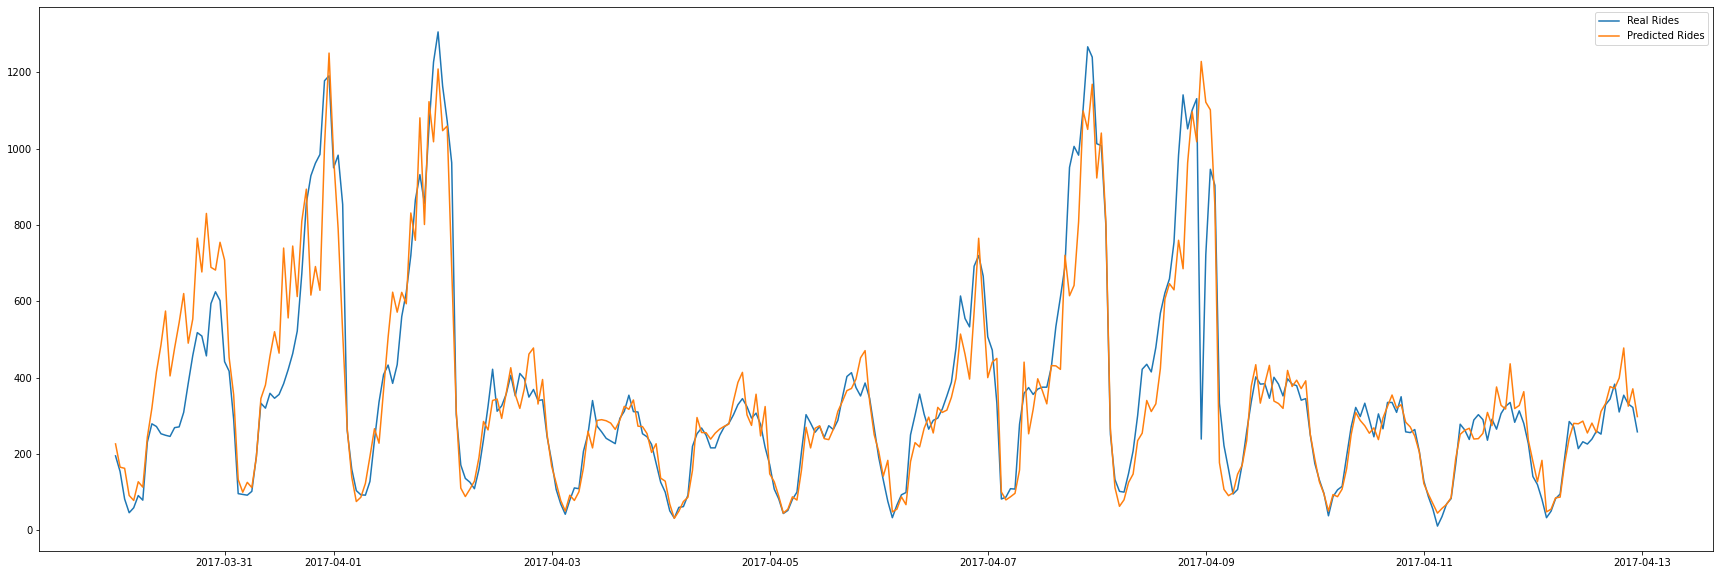

In [36]:
xtest_copy.index = test.created_on_hour
plt.plot(xtest_copy.y, label= 'Real Rides')
plt.plot(xtest_copy.y_pred_xgb,label = 'Predicted Rides')
plt.rcParams["figure.figsize"] = (30,10)
plt.legend()

### The importance plot shows that the previous week's rides feature is 'by far' the most important feature. Features that also contribute to the prediction are the month and the hour.

### * It's important to mention that a more correct way to perform the prediction is to perform a multi-step prediction. First, predict the first week's rides using the 'previous week's rides' feature from the training data, and only then, build the 'previous week rides' feature of the second week using the first week's predictions. 

## CASE 2 : SARIMAX model

In [37]:
import statsmodels.api as sm

#### SARIMAX is very 'heavy' and requires an extensive hyper-paramter search which take a very long time and resources (memory). Therefore, only one set of hyper-param is being used and, the model is trained on less than 500 data points. 

### It's important to mentions that this model can be optimized and provide better results. 
 

In [38]:
df_mrg.index = df_mrg.created_on_hour
df_train_sarimax = df_mrg.iloc[6000:train.index[-1],:].copy()
df_train_sarimax = df_train_sarimax[['rides']]

In [39]:
# SARIMAX can use exogenous features but this adds way more calculation time 
# Here, we use the time stamp and the number of rides as the only inputs to the model 
srm = sm.tsa.statespace.SARIMAX(df_train_sarimax['rides'], order=(1,0,1), seasonal_order=(1,0,1,168))
res = srm.fit(disp=False)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [40]:
# res.plot_diagnostics(figsize=(16, 8))
# plt.show()

In [41]:
pred = res.get_forecast(steps=336)

c:\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [42]:
mean_absolute_error(y_test,pred.predicted_mean)

114.77242489807477

In [43]:
xtest_copy['y_pred_sarimax'] = list(pred.predicted_mean)

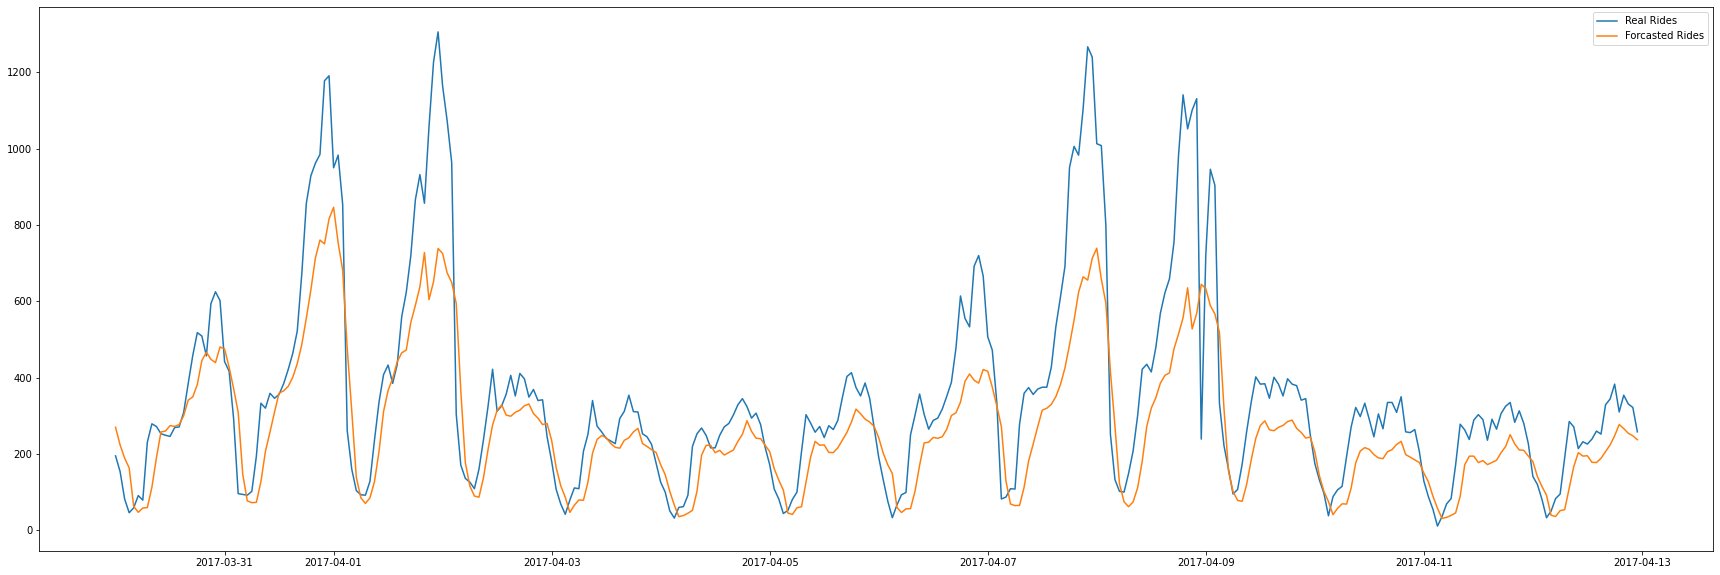

In [44]:
plt.plot(xtest_copy.y,label = 'Real Rides')
plt.plot(xtest_copy.y_pred_sarimax,label = 'Forcasted Rides')
plt.rcParams["figure.figsize"] = (40,10)
plt.legend()

# Summary : 

### The basline model, XGBoost and SARIMAX get MAE scores of 195.8, 68.8 and 114.7 respectively.  Both of the models get better results than the baseline model. A reliable model for future forecasts would be a SARIMAX model that is trained with exogenous features, with tuned hyper-params and on more data.
